## Run Mask R-CNN detection on image

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10., 8.)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import sys
sys.path.insert(0, '../tools')
import _init_paths
from model.config import cfg, cfg_from_file, cfg_from_list
from model.test import im_detect, _get_blobs
from model.nms_wrapper import nms

from datasets.factory import get_imdb
from nets.resnet_v1 import resnetv1
from utils.mask_utils import recover_masks

import os
import os.path as osp
import numpy as np
import cv2
from scipy.misc import imread
from pprint import pprint
import argparse

import torch

In [5]:
# mask rcnn inference instance
# frcn inference instance
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='coco_minus_refer', help='image databased trained on.')
parser.add_argument('--net', default='res101')
parser.add_argument('--iters', default=1250000, type=int)
parser.add_argument('--tag', default='notime')
args = parser.parse_args('')

In [6]:
# load dataset
if args.dataset == 'coco_minus_refer':
    TRAIN_IMDB="coco_2014_train_minus_refer_valtest+coco_2014_valminusminival"
    TEST_IMDB="coco_2014_minival"
imdb = get_imdb(TEST_IMDB)

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!


In [7]:
# define net
net = resnetv1(batch_size=1, num_layers=101)
net.eval(); net.cuda()
# load pretrained model
model_path = osp.join('../output', args.net, TRAIN_IMDB, args.tag, args.net+'_mask_rcnn_iter_'+str(args.iters)+'.pth')
print(('Loading model check point from {:s}').format(model_path))
# load cfg file
cfg_from_file('../experiments/cfgs/%s_from_frcn.yml' % args.net)

net.create_architecture(imdb.num_classes, tag='default',
                        anchor_scales=[4,8,16,32],
                        anchor_ratios=[0.5,1,2])
net.load_state_dict(torch.load(model_path))
net.eval(); net.cuda()
print('loaded')

Loading model check point from ../output/res101/coco_2014_train_minus_refer_valtest+coco_2014_valminusminival/notime/res101_mask_rcnn_iter_1250000.pth
loaded


In [40]:
# prepare image
# im_names = ['000456.jpg', '000542.jpg', '001150.jpg', '001763.jpg', '004545.jpg', 'fish_bike.jpg']
# im_file = osp.join('../data', 'demo', im_names[2])
# im = cv2.imread(im_file)
IMAGE_DIR = '../data/coco/images/test2014/'
im_files = [osp.join(IMAGE_DIR, im_file) for im_file in os.listdir(IMAGE_DIR)]
im_file = im_files[1479]
im = cv2.imread(im_file)
# detect
scores, boxes = im_detect(net, im)
# nms and threshold
CONF_THRESH = 0.65
NMS_THRESH = 0.3
cls_to_dets = {}
for cls_ind, cls in enumerate(imdb.classes[1:]):
    cls_ind += 1 # because we skipped background
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes, 
                      cls_scores[:, np.newaxis])).astype(np.float32)
    keep = nms(torch.from_numpy(dets), NMS_THRESH)
    dets = dets[keep.numpy(), :] 
    inds = np.where(dets[:, -1] >= CONF_THRESH)[0]
    dets = dets[inds, :]
    cls_to_dets[cls] = dets
    
# predict masks
blobs, im_scales = _get_blobs(im)
net_conv = net._predictions['net_conv']
cls_to_masks = {}
for cls, dets in cls_to_dets.items():
    if dets.shape[0] > 0:
        label = imdb._class_to_ind[cls]
        labels = np.array([label] * dets.shape[0], dtype=np.int)
        mask_prob = net._predict_masks_from_boxes_and_labels(net_conv, dets[:,:4]*im_scales[0], labels)
        mask_prob = mask_prob.data.cpu().numpy()
        cls_to_masks[cls] = recover_masks(mask_prob, dets[:, :4], im.shape[0], im.shape[1])

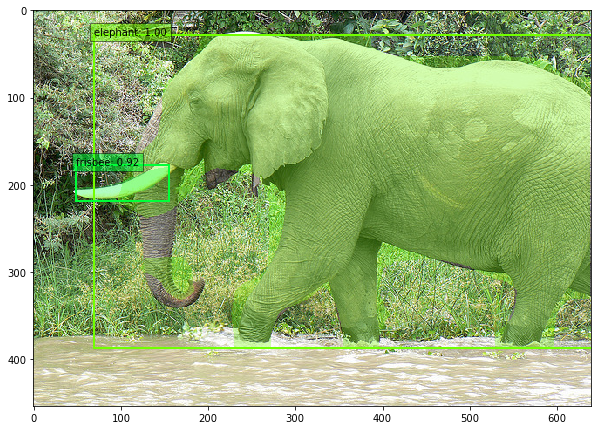

In [41]:
# visualize
colors = plt.cm.hsv(np.linspace(0, 1., imdb.num_classes)).tolist()
im = imread(im_file)
plt.imshow(im)
currentAxis = plt.gca()
for cls, dets in cls_to_dets.items():
    for i in range(dets.shape[0]):
        bbox = dets[i, :4]
        score = dets[i, -1]
        display_txt = '%s: %.2f'%(cls, score)
        coords = (bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1
        color = colors[imdb.classes.index(cls)]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(bbox[0], bbox[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})  
        # add mask
        m = cls_to_masks[cls][i] > 122. # uint8
        color_mask = np.random.random((1,3)).tolist()[0]
        img = np.ones( (m.shape[0], m.shape[1], 3) )
        for i in range(3):
            img[:,:,i] = color[i]
        currentAxis.imshow(np.dstack( (img, m*0.3) ))